## The Training

### 1st train

Runs with mixed data digit images and TMNIST percental images.
The best model will be stored as "eff100-best.h5"

### 2nd train

Runs only on the last layer again. The convolutional layers will not trained.

## The Model

Used a smaller variant of Efficientnet (effnet) network as small model.

<https://github.com/arthurdouillard/keras-effnet>


In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 400                     # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = False                # grayscale or rgb
model_filename = "output/eff100"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.class_encoding import *
from b2n.augmentation.generator import *


## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).


### Percental TMNIST

300.000 images of type face fonts in 0.1 steps from 0.0 to 9.9

See https://www.kaggle.com/datasets/frankhaverland/percentile-tmnist-for-electric-meters


### Train and Test data

For 1st train both dataset mixed are used.

### digit meter spread

The percental TMNIST has for every label the same count of data.

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  12697
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-21 21:05:05.767637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-21 21:05:05.767993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


dataset x_train-size=15877


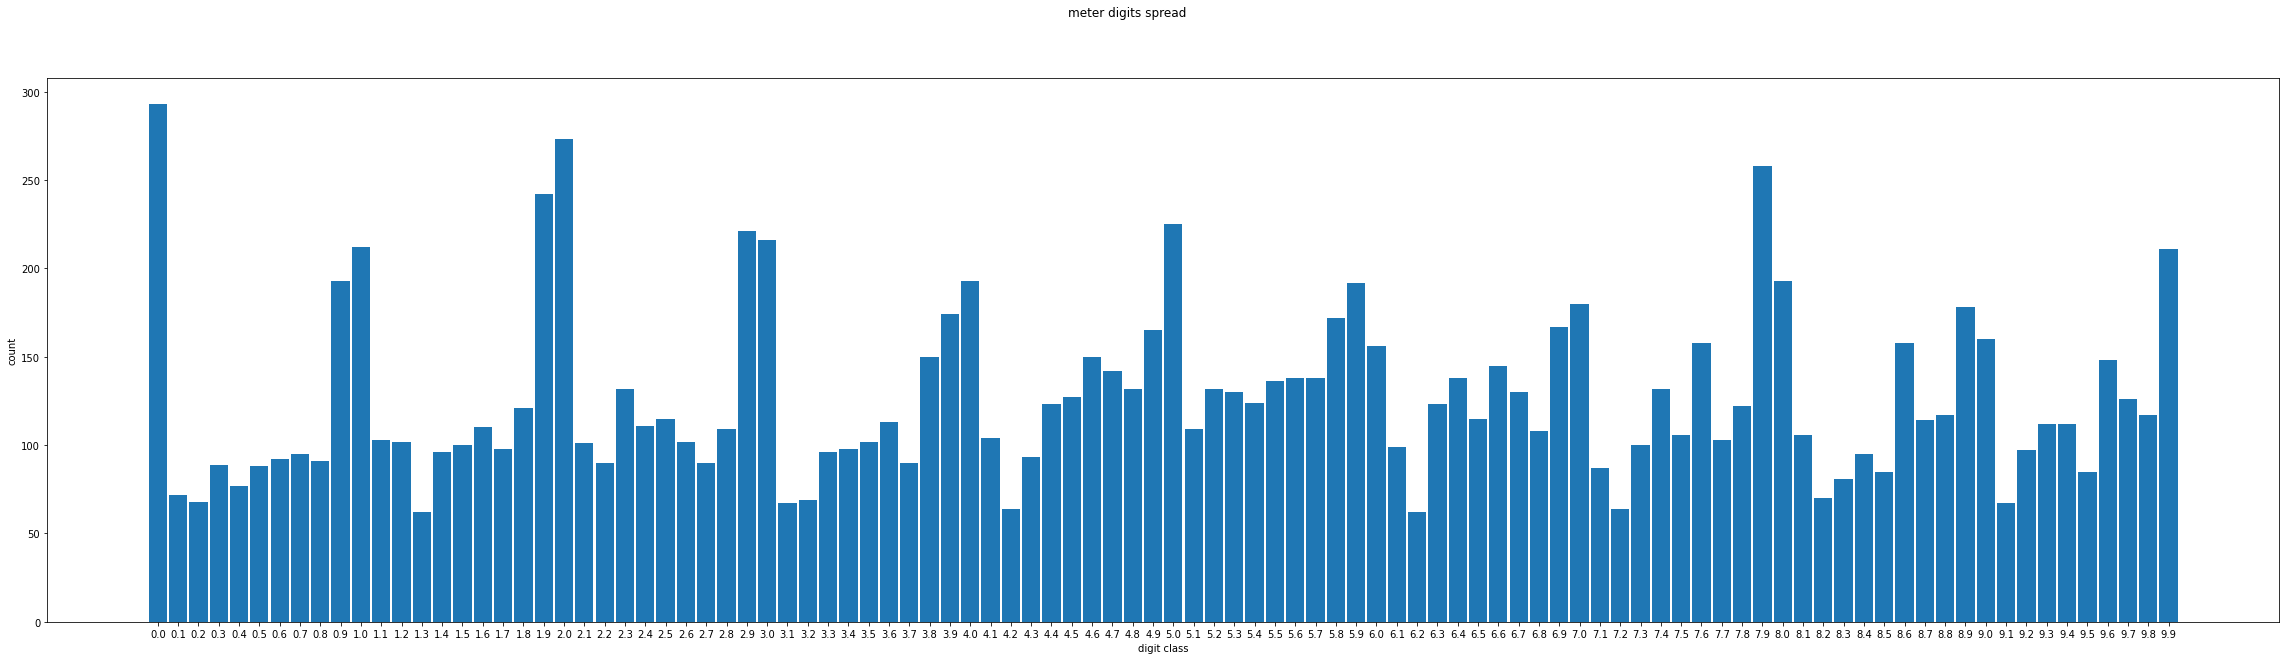

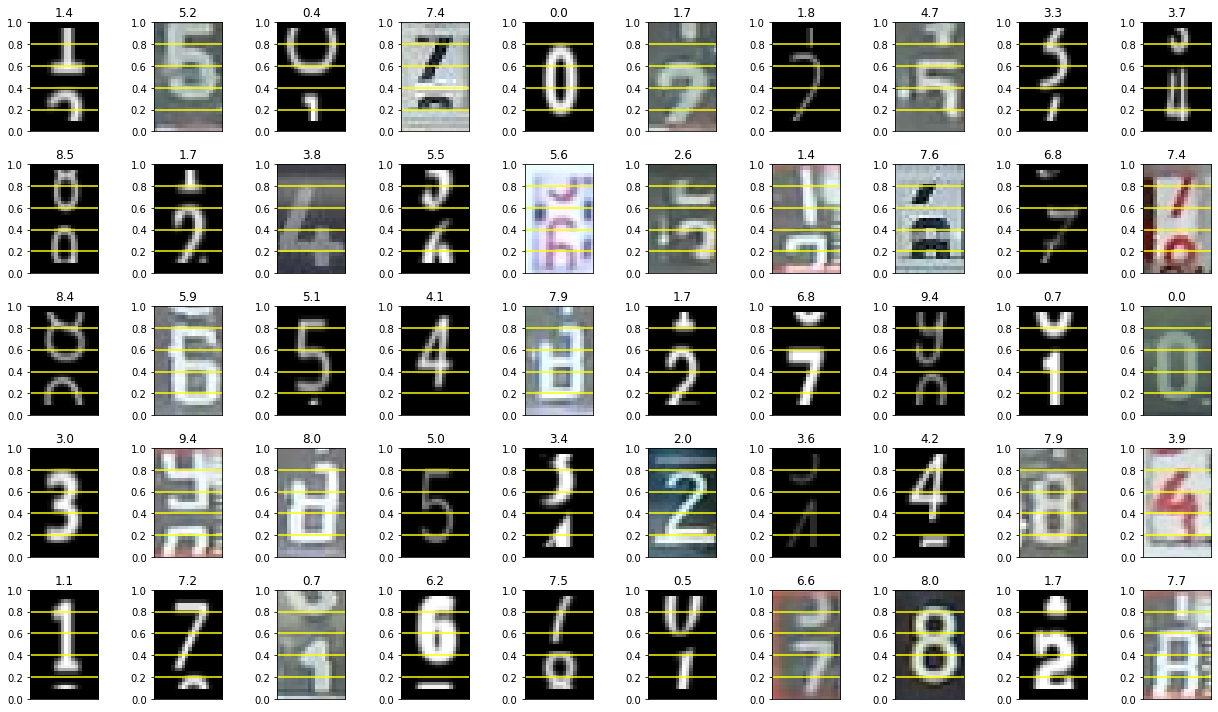

In [2]:


xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
xz_train, xz_test, yz_train, yz_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)


xt_data, yt_data = tmnist_percentals(max_count=1)

# mixing the datasets
x_data = np.concatenate((xt_data, xz_train))
y_data = np.concatenate((yt_data, yz_train))
x_data, y_data = shuffle(x_data, y_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

input_shape=x_train[0].shape
print(f"dataset x_train-size={len(x_train)}")
plot_dataset(x_train, y_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)

yz_train = class_encoding(yz_train, nb_classes)
yz_test = class_encoding(yz_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting and noising images.
Spot light is not used. It makes the train difficult without better results.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


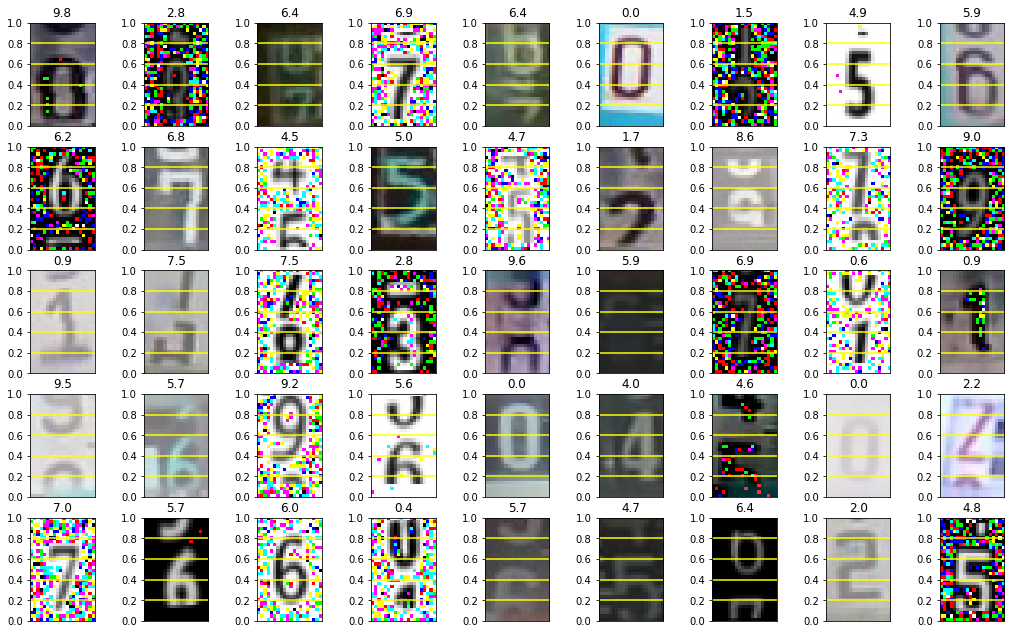

Validation data


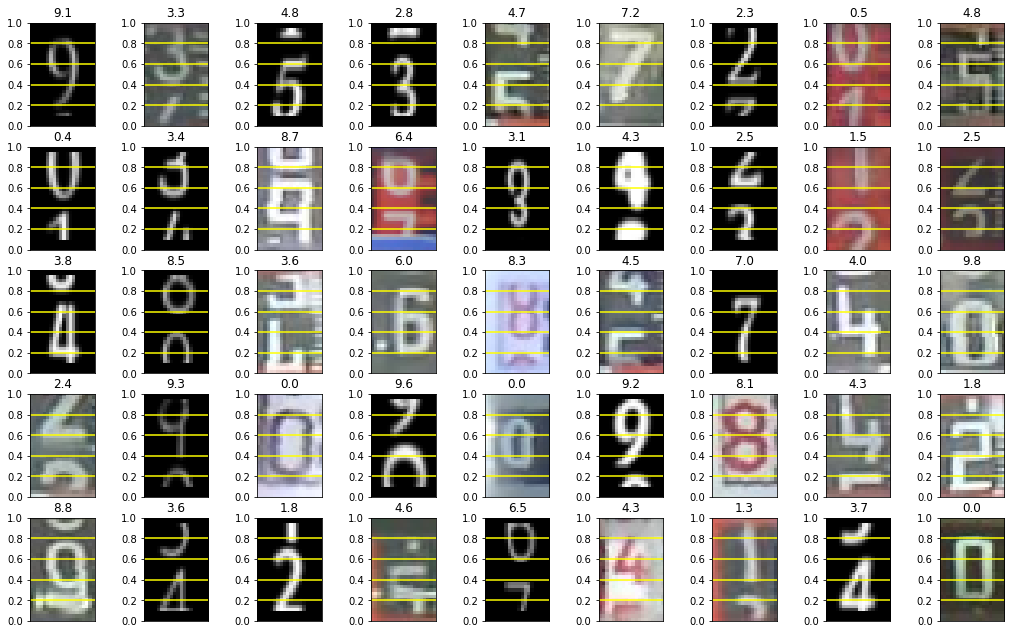

In [3]:
import numpy as np
from b2n.augmentation.generator import augmentation, no_augmentation
from b2n.plotfunctions import plot_dataset_it

train_iterator = augmentation(x_train, y_train)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 



In [4]:
import tensorflow as tf
from b2n.models.distiller import Distiller
from b2n.models.effnet import Effnet
from b2n.models.cnn32 import *

model = CNN_s1(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

Epoch 1/40


2022-06-21 21:05:12.912408: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-21 21:05:13.513022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


497/497 [==============================] - ETA: 0s - loss: 3.0735 - accuracy: 0.2934

2022-06-21 21:05:22.260066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.38791, saving model to output/eff100_best.h5
497/497 [==============================] - 11s 19ms/step - loss: 3.0735 - accuracy: 0.2934 - val_loss: 2.2408 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 2/40
497/497 [==============================] - ETA: 0s - loss: 1.7583 - accuracy: 0.5036
Epoch 2: val_accuracy improved from 0.38791 to 0.65063, saving model to output/eff100_best.h5
497/497 [==============================] - 11s 21ms/step - loss: 1.7583 - accuracy: 0.5036 - val_loss: 1.2728 - val_accuracy: 0.6506 - lr: 9.8000e-04
Epoch 3/40
495/497 [============================>.] - ETA: 0s - loss: 1.3605 - accuracy: 0.5760
Epoch 3: val_accuracy improved from 0.65063 to 0.66952, saving model to output/eff100_best.h5
497/497 [==============================] - 11s 23ms/step - loss: 1.3603 - accuracy: 0.5762 - val_loss: 1.0306 - val_accuracy: 0.6695 - lr: 9.6040e-04
Epoch 4/40
495/497 [============================>.] - ETA: 0s - loss: 1.1220 - acc

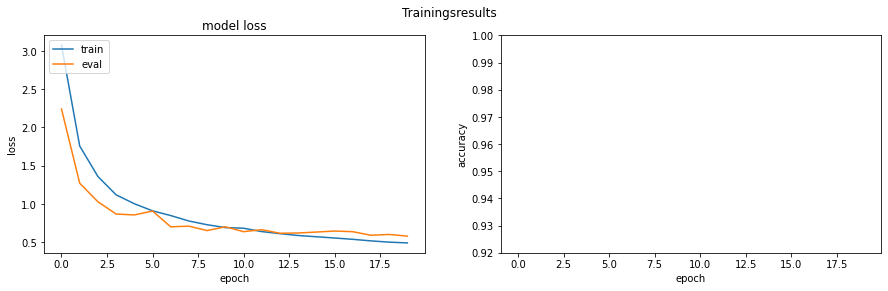

In [5]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from b2n.plotfunctions import plot_acc_loss, predict_meter_digits

earlystop = EarlyStopping(monitor='val_accuracy', mode='max' , patience=25, verbose=1,  restore_best_weights=True)
mc = ModelCheckpoint(model_filename + '_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-5, verbose=1)
history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[earlystop, mc, reduce_lr],
                verbose=1)


plot_acc_loss(history, "Trainingsresults")

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

 18/397 [>.............................] - ETA: 2s

2022-06-21 21:08:50.338916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 4s 10ms/step
Tested images: 12697. 332 false predicted. Accuracy is: 0.9738520910451288


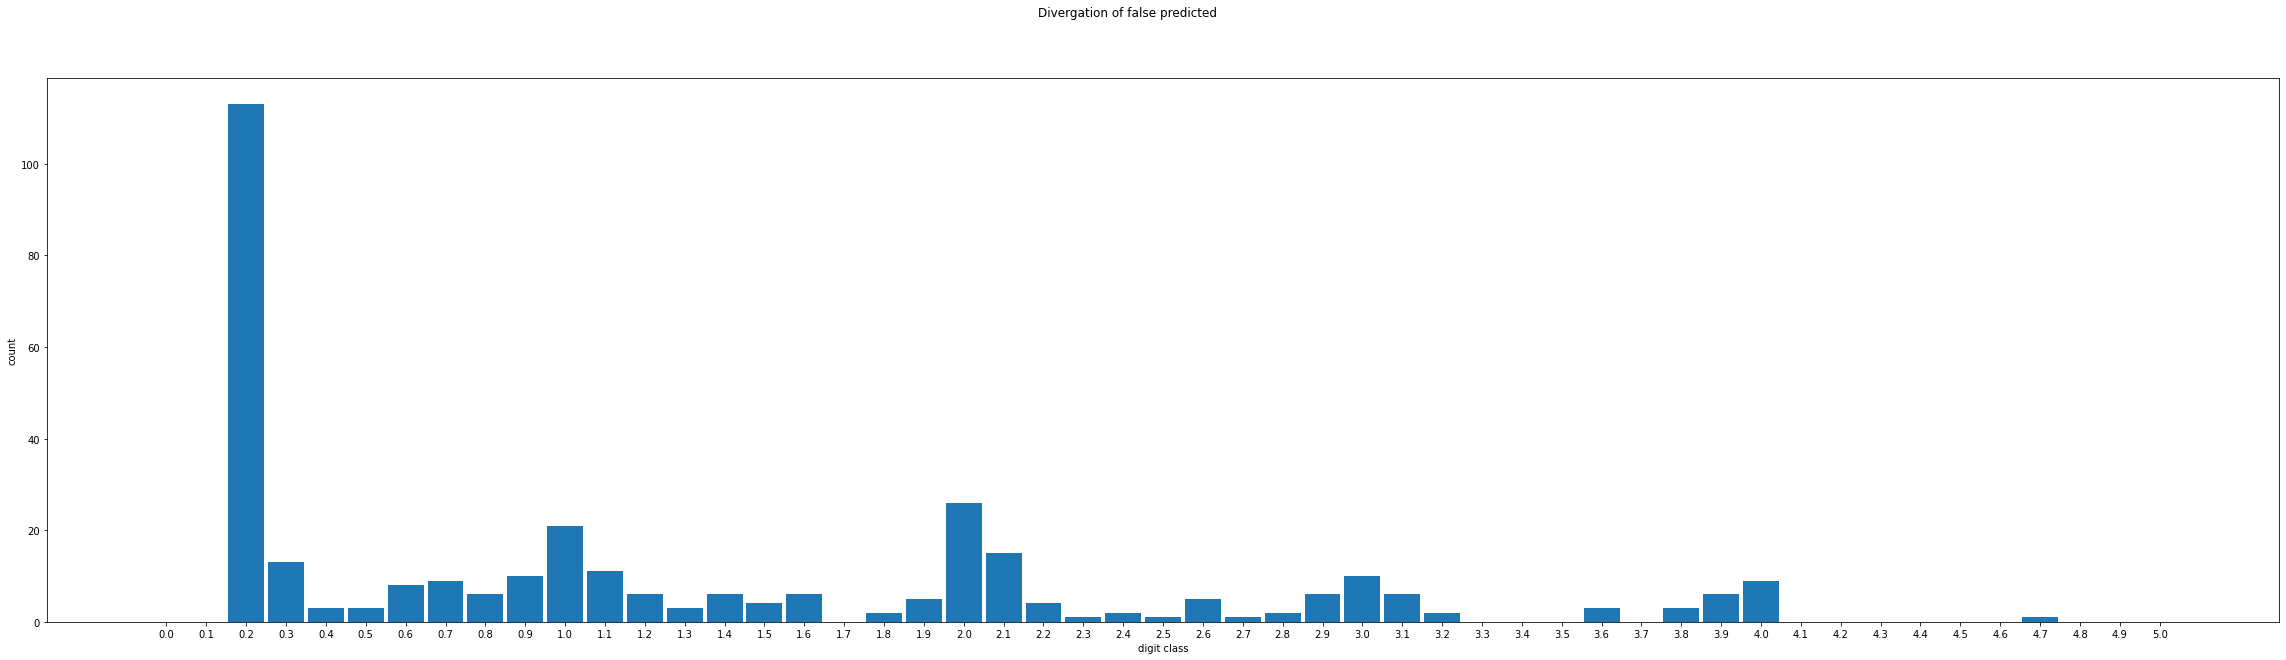

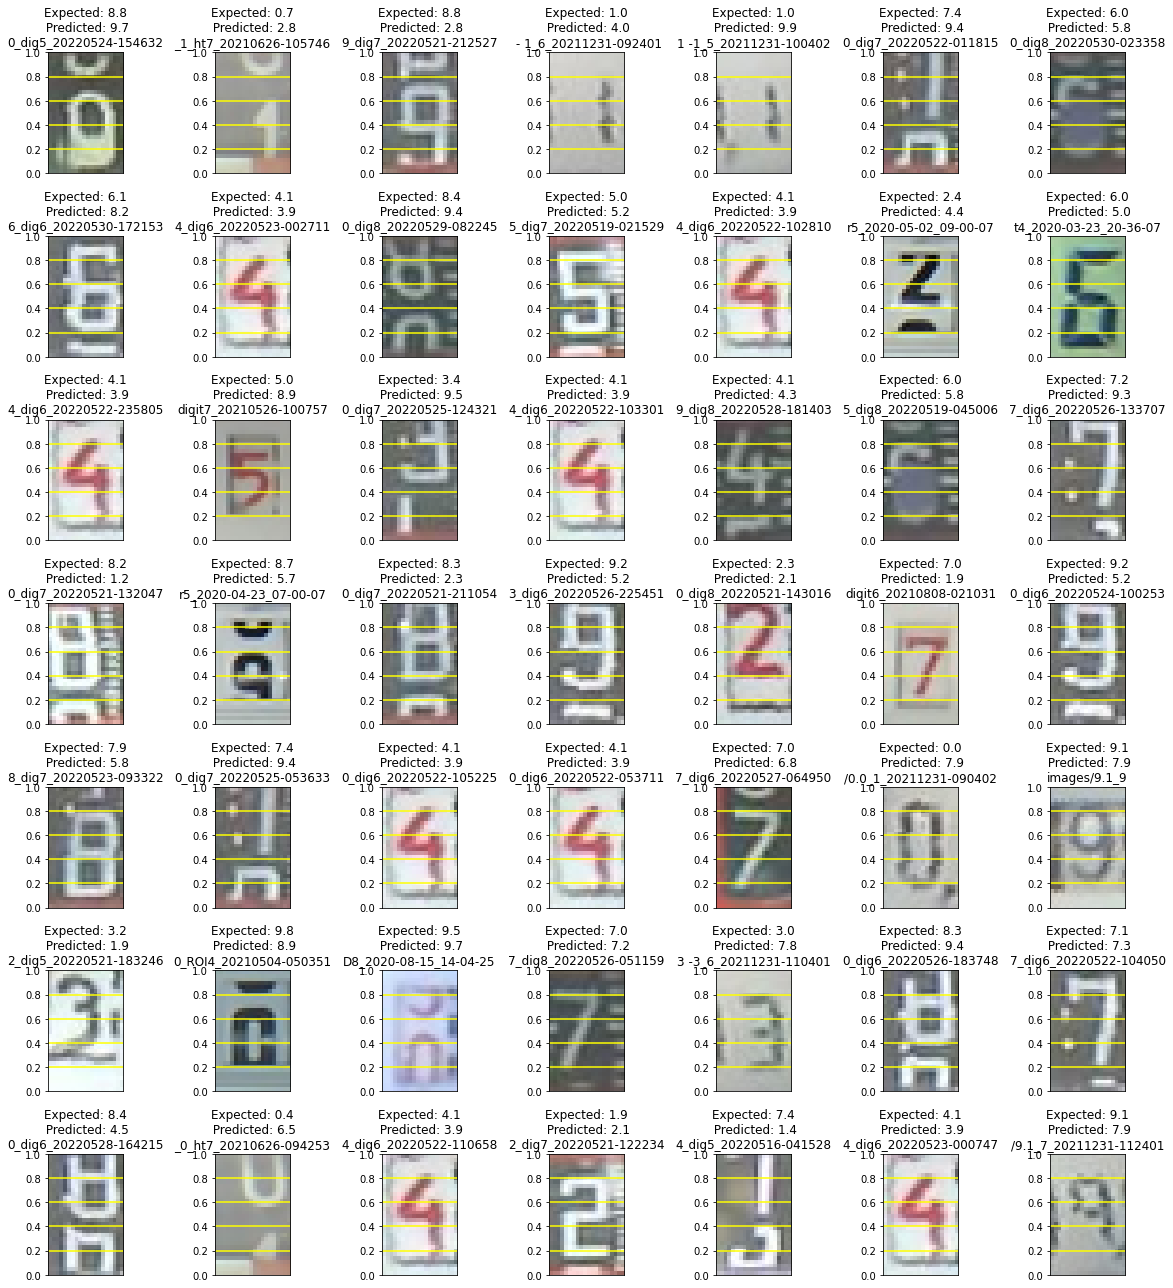

['images/8.8_10_dig5_20220524-154632.jpg',
 'images/0.7_1_ht7_20210626-105746.jpg',
 'images/8.8_9_dig7_20220521-212527.jpg',
 'images/1 - 1_6_20211231-092401.jpg',
 'images/1 -1_5_20211231-100402.jpg',
 'images/7.4_10_dig7_20220522-011815.jpg',
 'images/6.0_10_dig8_20220530-023358.jpg',
 'images/6.1_6_dig6_20220530-172153.jpg',
 'images/4.1_4_dig6_20220523-002711.jpg',
 'images/8.4_10_dig8_20220529-082245.jpg',
 'images/5.0_5_dig7_20220519-021529.jpg',
 'images/4.1_4_dig6_20220522-102810.jpg',
 'images/2.4000000000000004_ziffer5_2020-05-02_09-00-07.jpg',
 'images/6_digit4_2020-03-23_20-36-07.jpg',
 'images/4.1_4_dig6_20220522-235805.jpg',
 'images/5_5_digit7_20210526-100757.jpg',
 'images/3.4_10_dig7_20220525-124321.jpg',
 'images/4.1_4_dig6_20220522-103301.jpg',
 'images/4.1_9_dig8_20220528-181403.jpg',
 'images/6.0_5_dig8_20220519-045006.jpg',
 'images/7.2_7_dig6_20220526-133707.jpg',
 'images/8.2_10_dig7_20220521-132047.jpg',
 'images/8.7_ziffer5_2020-04-23_07-00-07.jpg',
 'images/

In [6]:
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data)

### 2nd train

Now the model will be trained like transfer learning <https://keras.io/guides/transfer_learning/>.

All layers except the top layer will be fixed and not trained in the 2nd training.

As dataset the digit meter images are used.

Train data


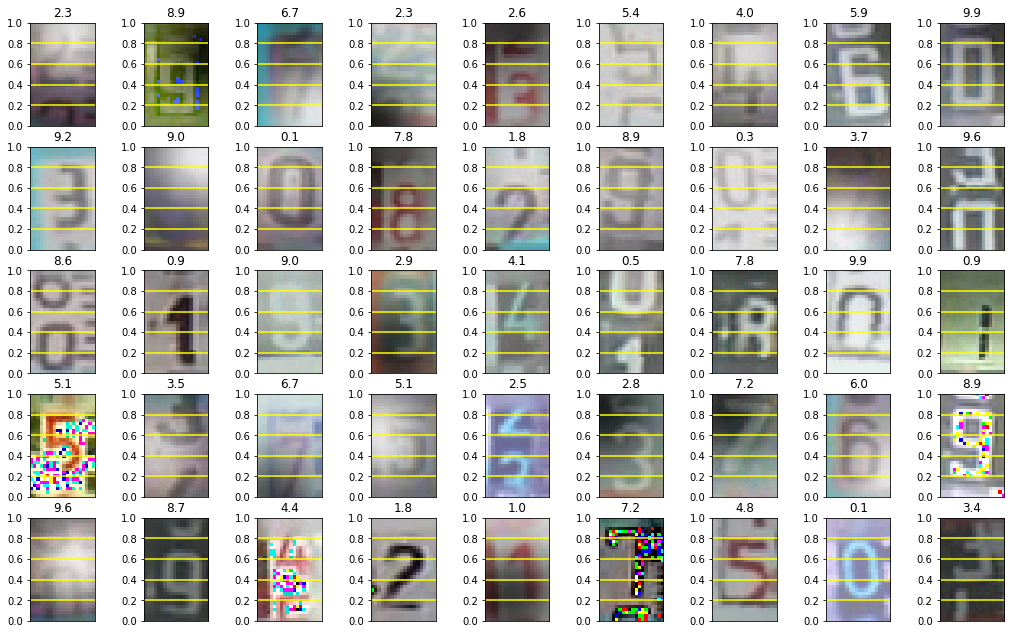

Validation data


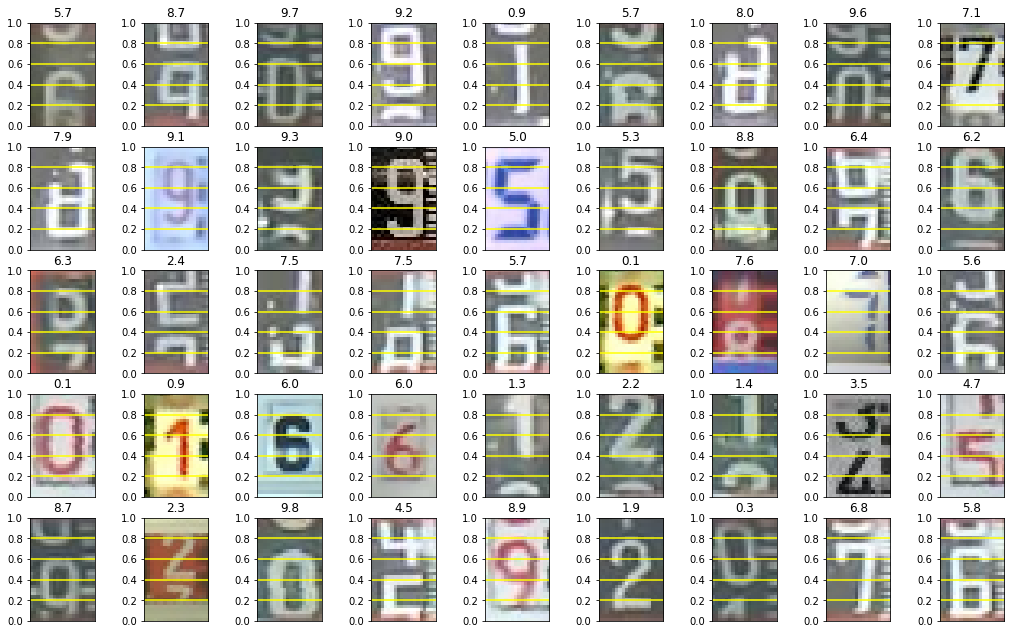

Epoch 1/20


2022-06-21 21:09:04.360885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-21 21:09:11.054717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.69449, saving model to output/eff100_best_transfer.h5
318/318 - 8s - loss: 1.0752 - accuracy: 0.6425 - val_loss: 0.8542 - val_accuracy: 0.6945 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.69449 to 0.70984, saving model to output/eff100_best_transfer.h5
318/318 - 7s - loss: 1.0101 - accuracy: 0.6548 - val_loss: 0.8250 - val_accuracy: 0.7098 - lr: 9.8000e-04 - 7s/epoch - 20ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.70984
318/318 - 7s - loss: 0.9878 - accuracy: 0.6634 - val_loss: 0.8484 - val_accuracy: 0.7016 - lr: 9.6040e-04 - 7s/epoch - 22ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.70984
318/318 - 6s - loss: 0.9513 - accuracy: 0.6759 - val_loss: 0.8175 - val_accuracy: 0.7091 - lr: 9.4119e-04 - 6s/epoch - 20ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.70984
318/318 - 7s - loss: 0.9046 - accuracy: 0.6895 - val_loss: 0.8561 - val_accuracy: 0

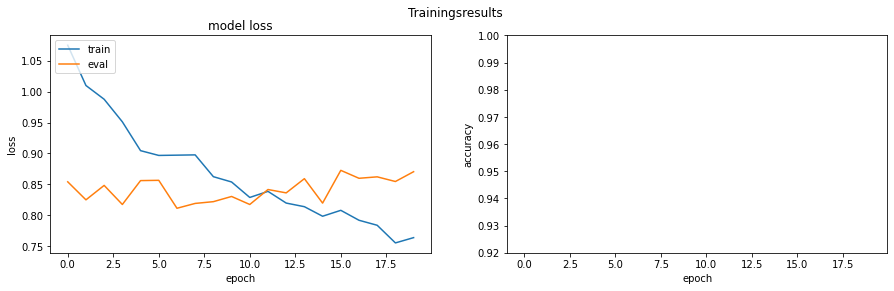

In [7]:
import numpy as np

model = keras.models.load_model(model_filename + '_best.h5')

# now whith meter digits
train_iterator = augmentation(xz_train, yz_train)
validation_iterator = no_augmentation(xz_test, yz_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 

# only the last layer is now trainable
for layer in model.layers[:-1]:
    layer.trainable=False

mc = ModelCheckpoint(model_filename + '_best_transfer.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 20,
                callbacks=[annealer, earlystop, mc],
                verbose=2)


model.save(model_filename + "_best_transfer.h5")

plot_acc_loss(history, "Trainingsresults")


### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

 21/397 [>.............................] - ETA: 1s

2022-06-21 21:11:13.889658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 3s 8ms/step
Tested images: 12697. 176 false predicted. Accuracy is: 0.9861384579034418


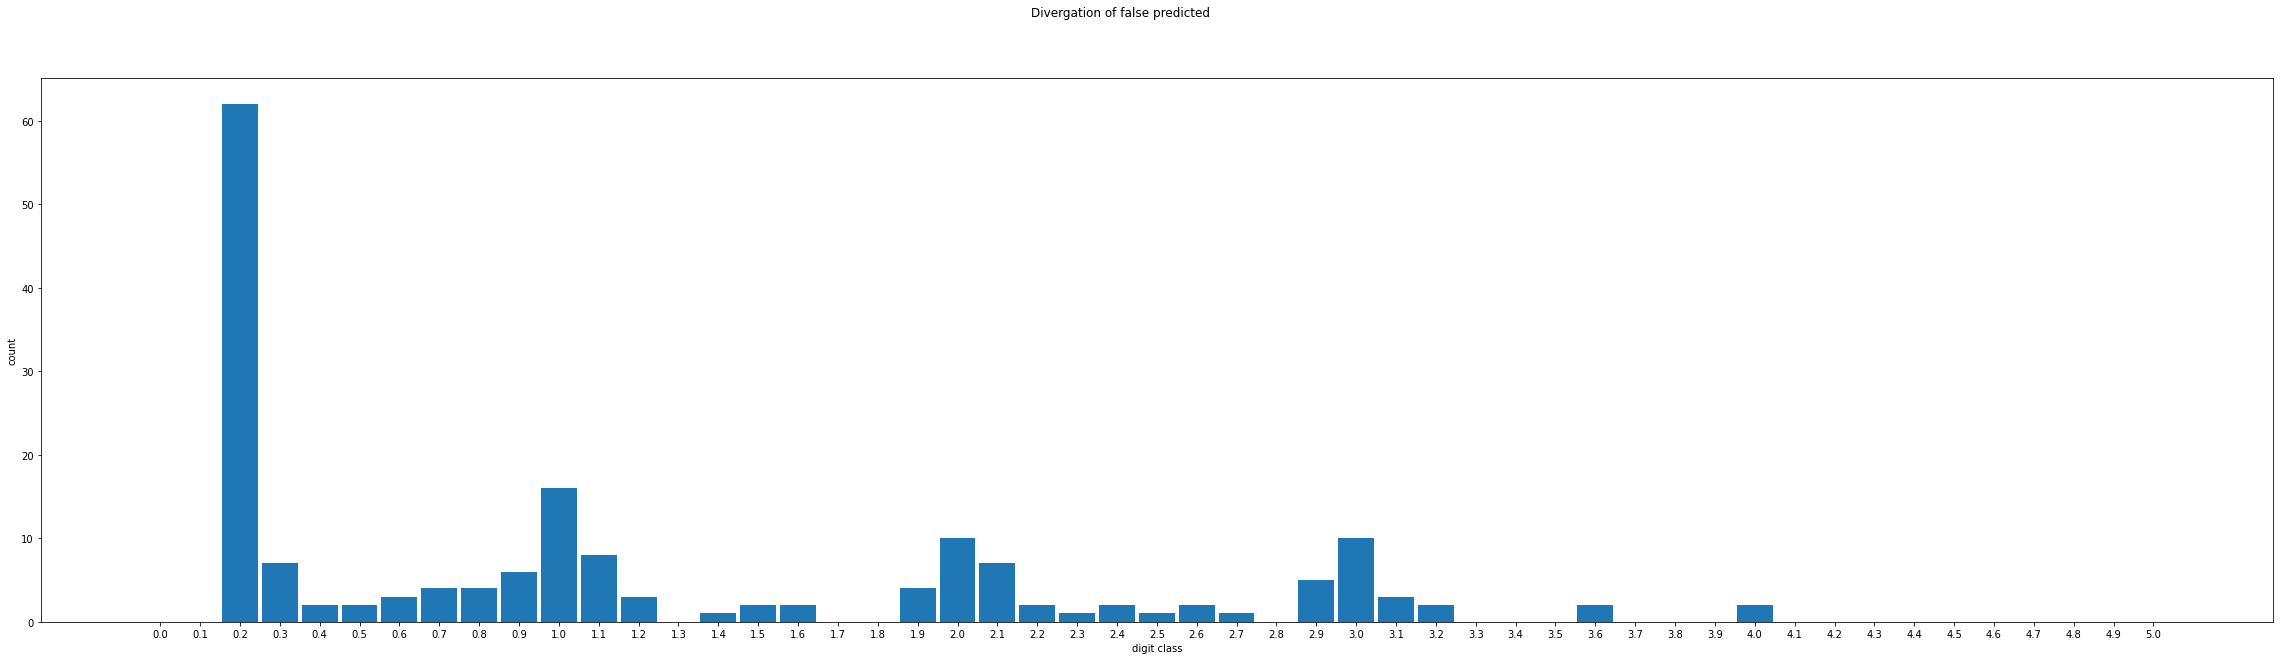

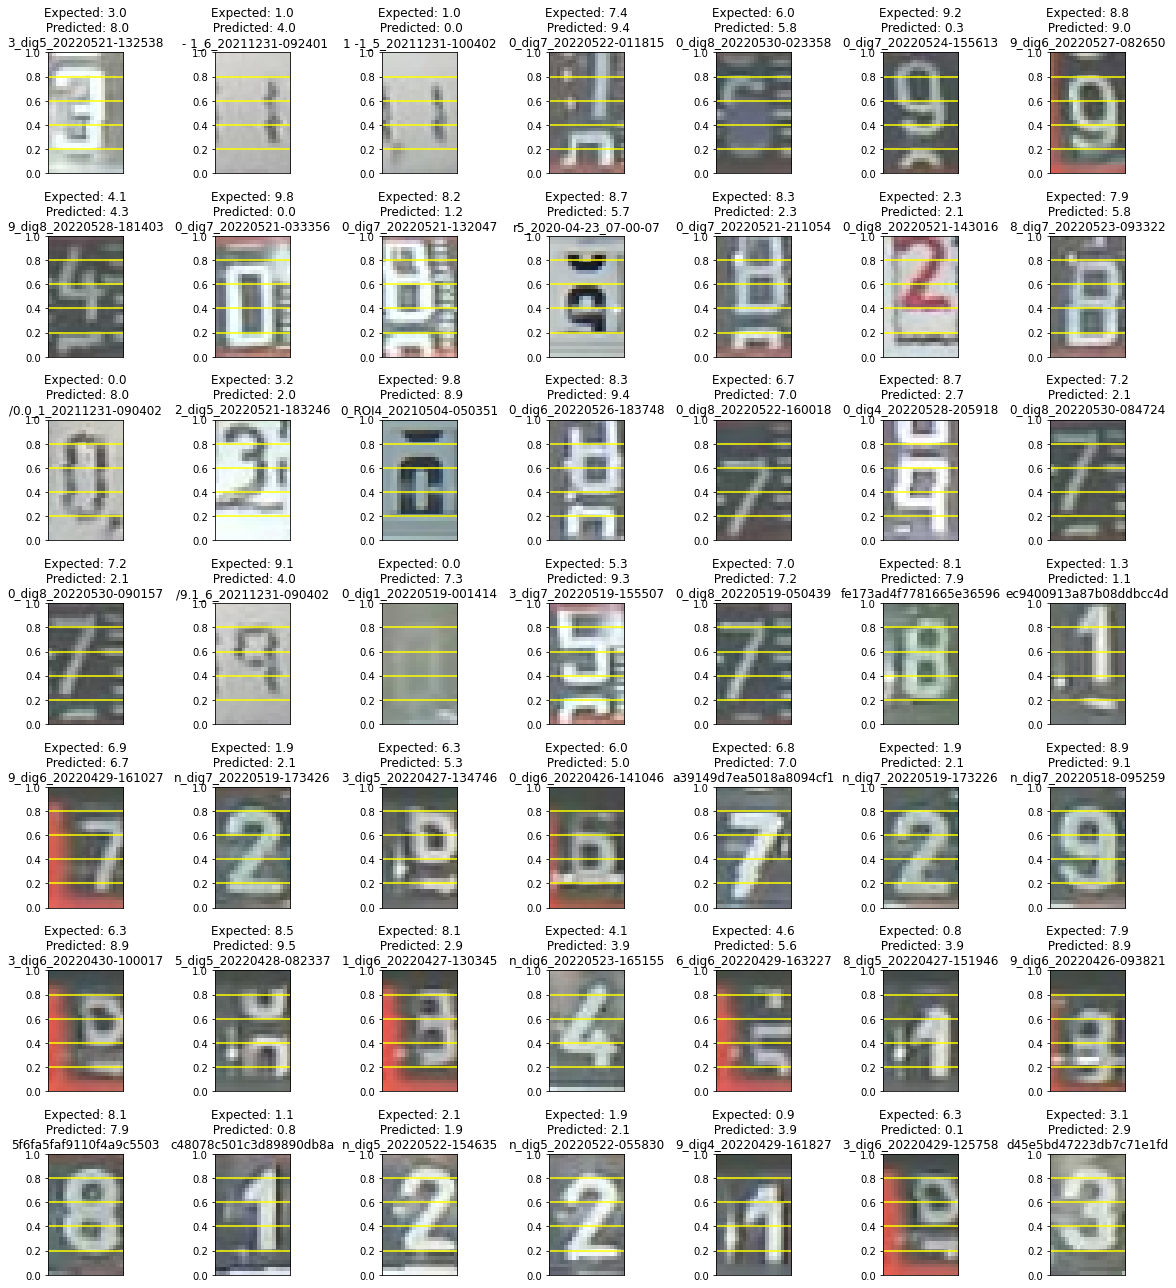

['images/3.0_3_dig5_20220521-132538.jpg',
 'images/1 - 1_6_20211231-092401.jpg',
 'images/1 -1_5_20211231-100402.jpg',
 'images/7.4_10_dig7_20220522-011815.jpg',
 'images/6.0_10_dig8_20220530-023358.jpg',
 'images/9.2_10_dig7_20220524-155613.jpg',
 'images/8.8_9_dig6_20220527-082650.jpg',
 'images/4.1_9_dig8_20220528-181403.jpg',
 'images/9.8_0_dig7_20220521-033356.jpg',
 'images/8.2_10_dig7_20220521-132047.jpg',
 'images/8.7_ziffer5_2020-04-23_07-00-07.jpg',
 'images/8.3_10_dig7_20220521-211054.jpg',
 'images/2.3_10_dig8_20220521-143016.jpg',
 'images/7.9_8_dig7_20220523-093322.jpg',
 'images/0.0_1_20211231-090402.jpg',
 'images/3.2_2_dig5_20220521-183246.jpg',
 'images/9.8_0_ROI4_20210504-050351.jpg',
 'images/8.3_10_dig6_20220526-183748.jpg',
 'images/6.7_10_dig8_20220522-160018.jpg',
 'images/8.7_10_dig4_20220528-205918.jpg',
 'images/7.2_10_dig8_20220530-084724.jpg',
 'images/7.2_10_dig8_20220530-090157.jpg',
 'images/9.1_6_20211231-090402.jpg',
 'images/emeter1/20220519/00/0_dig1

In [8]:
model = keras.models.load_model(model_filename + "_best_transfer.h5")
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data)